In [1]:
ROOT = "/opt/ml"
import sys
import os
sys.path.append(ROOT)
os.chdir(ROOT)
# GPU ID
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import PIL.Image as Image
import cv2
import numpy as np
import json,glob,re

import torch
import torchvision

from models import build_model
from transformers import RobertaTokenizerFast
import datasets.transforms as T
from datasets.refexp import build as build_refexp
from datasets.refego import RefEgoDataset
from util.misc import NestedTensor
from util.bbox_utils import * 

device = "cuda"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
ckpt = "checkpoints/refego_mdetr_binary_scratch.pth"
training_type="allimages_BH"

if training_type=="allimages_BH":
    binary_head = True
    
    ckpt = torch.load(ckpt,map_location=torch.device('cpu'))
    # print(ckpt['epoch'])
    # ckpt.keys()
    # ckpt['args'].binary_head = True
    
    ckpt['args'].freeze_backbone = False
    ckpt['args'].predict_final = False
    ckpt['args'].no_detection = False

    if not binary_head:
        ckpt['args'].do_qa = False
        ckpt['args'].split_qa_heads = None
else:
    print("wrong training_type of",training_type)
    quit()

print(ckpt['args'])
print(ckpt['args'].combine_datasets)
model, criterion, contrastive_criterion, qa_criterion, weight_dict = build_model(ckpt['args'])
# model.load_state_dict(ckpt['model'])
model.load_state_dict(ckpt['model_ema'])
model.to(device)
model.eval()

 # pre-process
text_encoder_type = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(text_encoder_type)
max_size = 1333
image_composer = T.Compose(
    [
        T.RandomResize([800], max_size=max_size),
        T.Compose(
            [
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        ),
    ]
)

Namespace(aux_loss=True, backbone='timm_tf_efficientnet_b3_ns', batch_size=4, bbox_loss_coef=5, binary_head=True, ce_loss_coef=1, clevr_ann_path='', clevr_img_path='', clip_max_norm=0.1, coco_path='', combine_datasets=['refego'], combine_datasets_val=['refego'], contrastive_align_loss=True, contrastive_align_loss_coef=1, contrastive_loss=False, contrastive_loss_coef=0.1, contrastive_loss_hdim=64, dataset_config='configs/refego.json', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_backend='nccl', dist_url='env://', distributed=True, do_qa=False, dropout=0.1, ema=True, ema_decay=0.9998, enc_layers=6, eos_coef=0.1, epoch_chunks=-1, epochs=5, eval=False, eval_skip=1, fraction_warmup_steps=0.01, freeze_backbone=False, freeze_text_encoder=False, frozen_weights=None, giou_loss_coef=2, gpu=0, hidden_dim=256, load='./data/pretrained/pretrained_EB3_checkpoint.pth', lr=0.0001, lr_backbone=1e-05, lr_drop=3, mask_loss_coef=1, mask_model='none', masks=False

# Inference

In [4]:
print(f"Loading sample jpgs")

imgs = [
    'sample_images/kitchen_takeaway.jpg',
    'sample_images/kitchen_takeaway.jpg',
    'sample_images/tree_and_gifts.jpg',
    'sample_images/tree_and_gifts.jpg',
]

# samples_list = []
# for img_path in imgs:
    
#     orig_img = 
#     img, _ = 
pil_imgs = [Image.open(img).convert("RGB") for img in imgs]
samples = NestedTensor.from_tensor_list(
    [image_composer(pil_img, None)[0] for pil_img in pil_imgs],
    False
).to(device)
    # samples_list.append(samples)

resultss=[]
captions = [
    'the coke can on the right',
    'the coke can on the table',
    'the big orange gift box by the tree',
    'the big orange gift box on the chair',
]
results = dict(
    pred_logits=[],
    pred_boxes=[],
    proj_queries=[],
    proj_tokens=[],
    pred_answer_binary=[],
    scores=[],
    pred_boxes_top1=[],
    pred_logits_top1=[],
)

# samples = samples_list[0]
# for samples in sample:
# for samples,caption in zip(samples_list,captions):

with torch.no_grad():
    memory_cache = model(samples, captions, encode_and_save=True)
    outputs = model(samples, captions, encode_and_save=False, memory_cache=memory_cache)
# tokenized = outputs['tokenized']

input_ids = outputs['tokenized']['input_ids'].cpu().numpy()
pred_logits = outputs['pred_logits'].cpu().numpy()
pred_boxes = outputs['pred_boxes'].cpu().numpy()
proj_queries = outputs['proj_queries'].cpu().numpy()
proj_tokens = outputs['proj_tokens'].cpu().numpy()
pred_answer_binary = outputs['pred_answer_binary'].sigmoid().cpu().numpy()

probs = outputs['pred_logits'].softmax(dim=-1).cpu().numpy()
scores = 1 - probs[:, :, -1]

top1_idx = np.argmax(scores,axis=-1)
pred_boxes_list_top1 = pred_boxes[np.arange(len(pil_imgs)),top1_idx]

for idx,pil_img in enumerate(pil_imgs):
    w, h = pil_img.size
    pred_boxes_top1 = denormalize(xywh2xyxy(pred_boxes_list_top1[idx]), h, w)
    pred_logits_top1 = pred_logits[idx,top1_idx[idx],-1]
    print("pred_boxes_top1",pred_boxes_top1[idx], h, w)
    print("pred_logits_top1",pred_logits_top1)
    results['pred_boxes_top1'].append(pred_boxes_top1)
    results['pred_logits_top1'].append(pred_logits_top1)

results['pred_logits'].extend([x for x in pred_logits])
results['pred_boxes'].extend([x for x in pred_boxes])
results['proj_queries'].extend([x for x in proj_queries])
results['proj_tokens'].extend([x for x in proj_tokens])
results['pred_answer_binary'].extend([x for x in pred_answer_binary])
results['scores'].extend([x for x in scores])

# save
print(f'Saving to refego_sample.json')
json.dump({k:[v.tolist() for v in vs] for k,vs in results.items()},open(f'refego_sample.json','w'))
print('done.')

Loading sample jpgs
pred_boxes_top1 379.52094 960 1280
pred_logits_top1 2.3338683
pred_boxes_top1 761.2506 960 1280
pred_logits_top1 3.5317001
pred_boxes_top1 893.24475 960 1280
pred_logits_top1 2.5206807
pred_boxes_top1 882.20056 960 1280
pred_logits_top1 4.4750457
Saving to refego_sample.json
done.


# Visualize

Visualizing samples jpgs with threshold=0.8

RE: "the coke can on the right"
The score of the object "the coke can on the right" in the sample_images/kitchen_takeaway.jpg: 0.8904775
The target object is at [ 379 765 449 867 ]


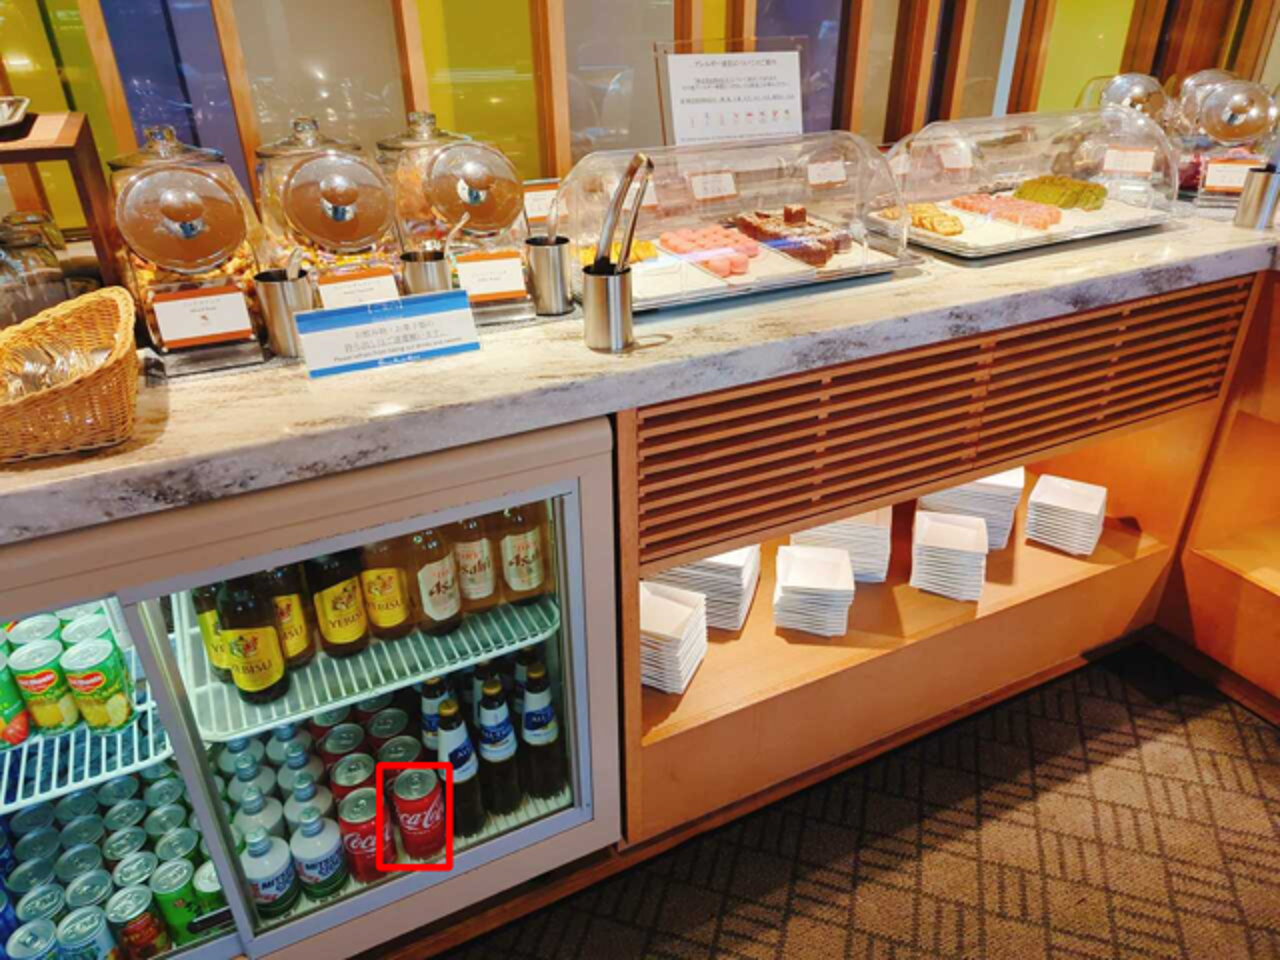


RE: "the coke can on the table"
The score of the object "the coke can on the table" in the sample_images/kitchen_takeaway.jpg: 0.17571214
No target object.


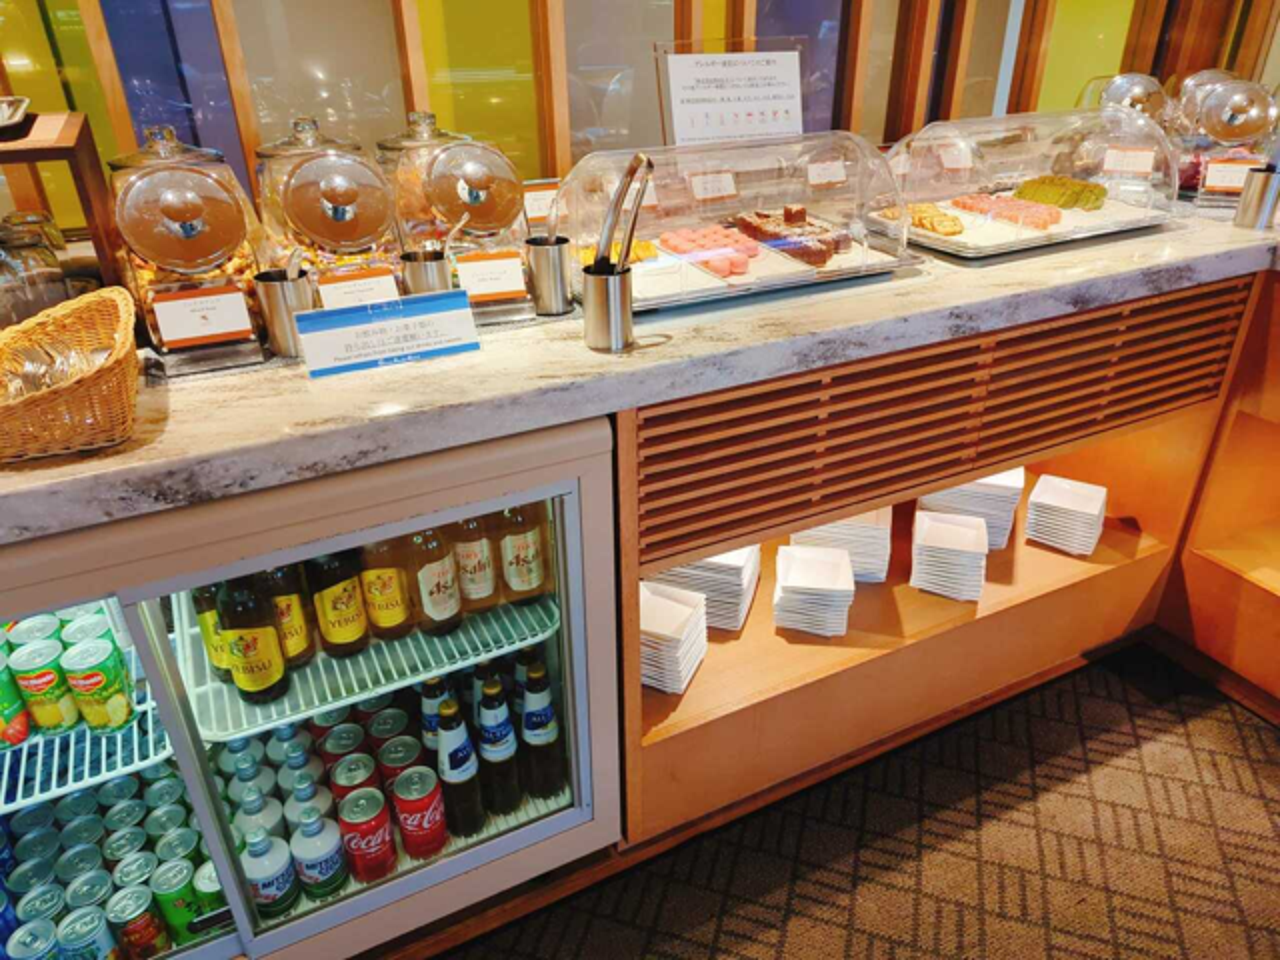


RE: "the big orange gift box by the tree"
The score of the object "the big orange gift box by the tree" in the sample_images/tree_and_gifts.jpg: 0.9445935
The target object is at [ 811 774 893 879 ]


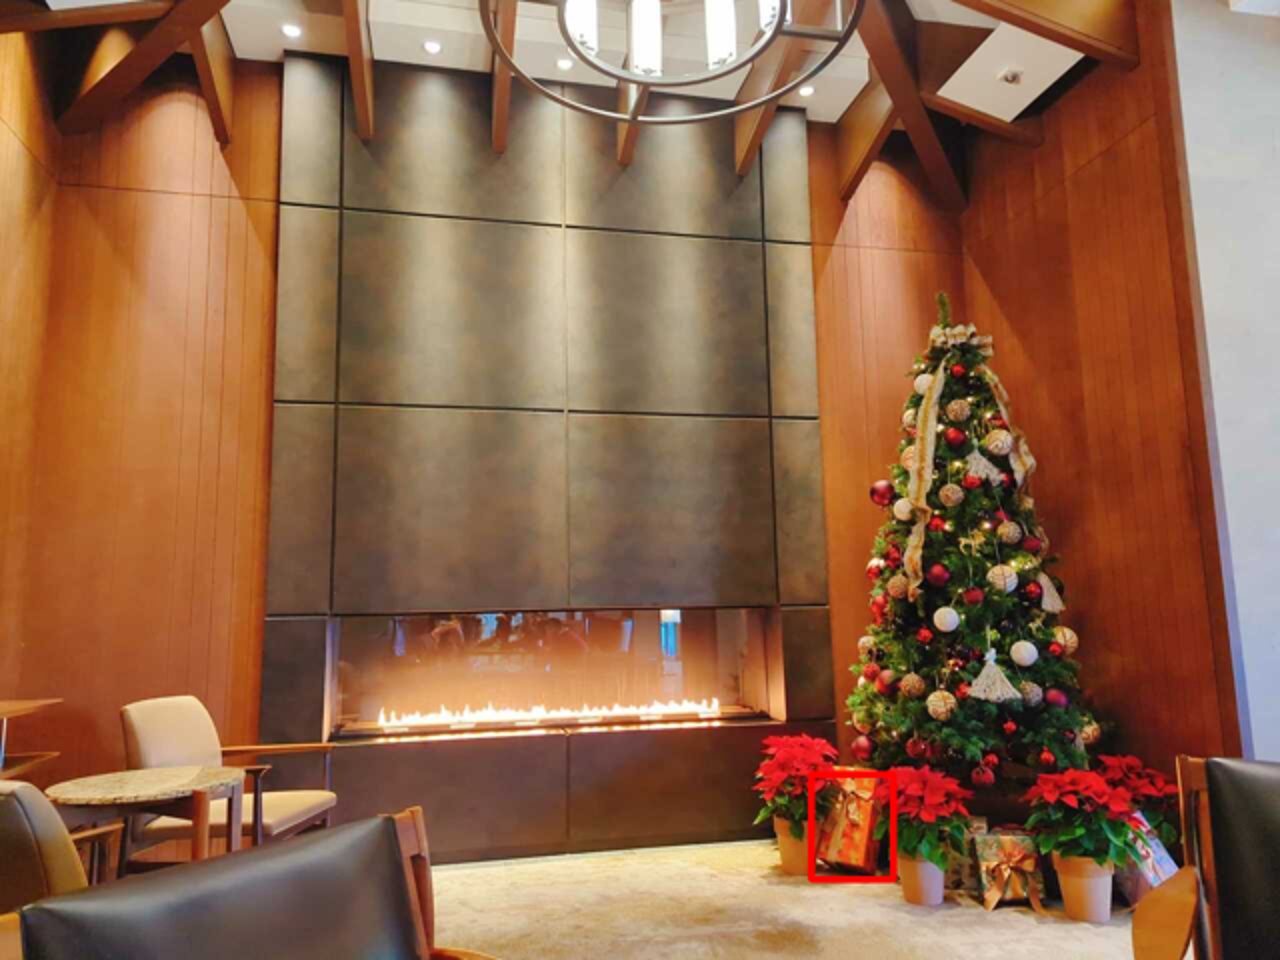


RE: "the big orange gift box on the chair"
The score of the object "the big orange gift box on the chair" in the sample_images/tree_and_gifts.jpg: 0.076864876
No target object.


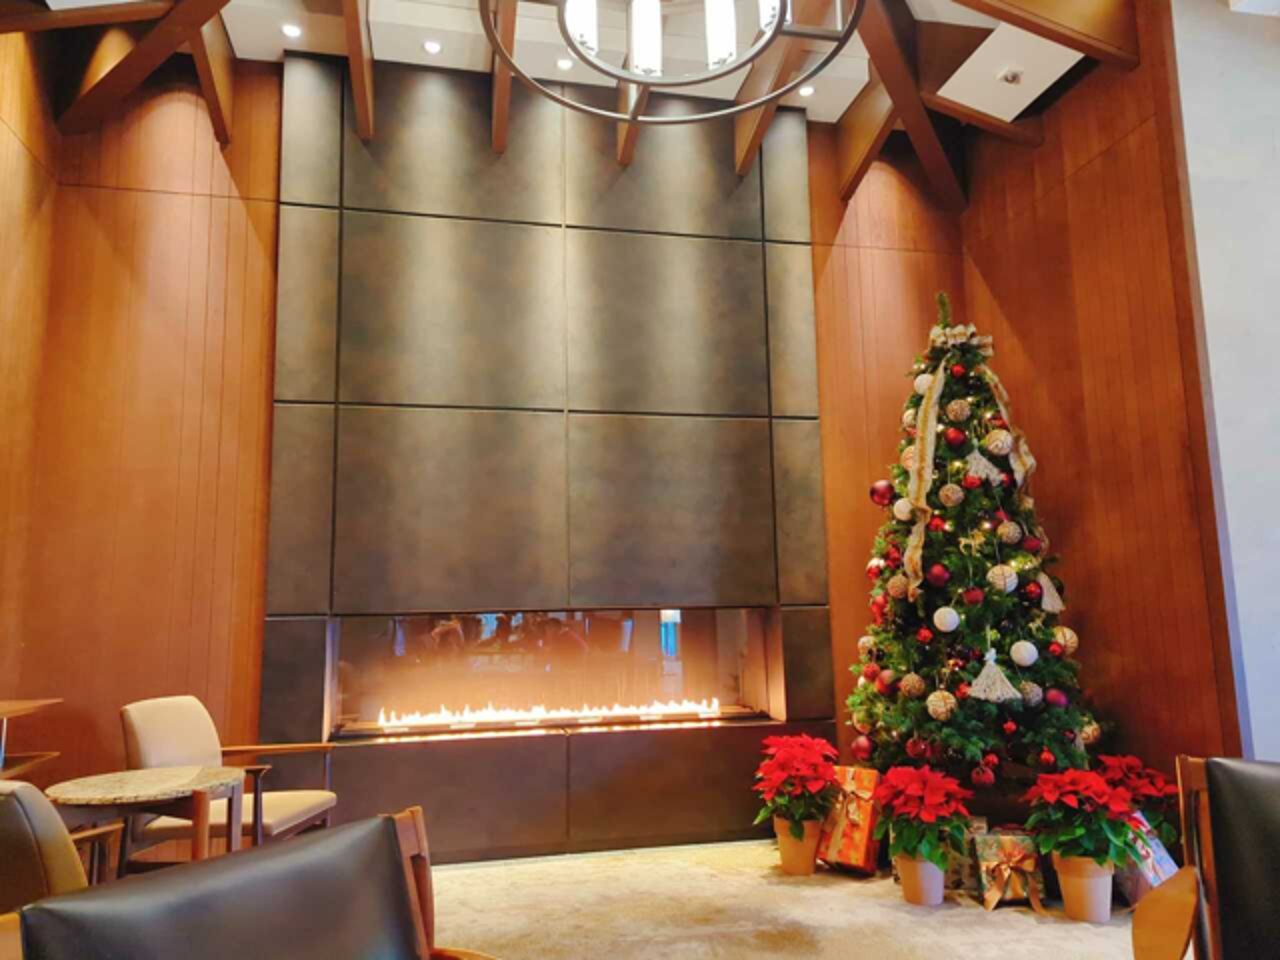

In [5]:
threshold = 0.8

print(f"Visualizing samples jpgs with threshold={threshold}")
print("")

for idx,(img,caption) in enumerate(zip(imgs,captions)):
    im = Image.open(img)
    visualize = np.array(im)
    x1,y1,x2,y2 = results['pred_boxes_top1'][idx]
    binary = results['pred_answer_binary'][idx]

    print(f'RE: "{caption}"')
    print(f'The score of the object "{caption}" in the {img}:', binary)
    if binary>threshold:
        print("The target object is at [",int(x1), int(y1), int(x2), int(y2),"]")
        cv2.rectangle(visualize, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 5)
    else:
        print("No target object.")
    
    im = Image.fromarray(visualize)
    width, height = im.size
    im = im.resize((width//2,height//2)) # show in 1/2 scale
    im = im.resize((width,height))
    display(im)
    print("")